# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

Here we want to scale down to simpler models to understand better the dynamics between the main and the collateral task. In fact, we will limit ourselves to feed forward networks with a single hidden layer the size of which will be studied through out this notebook. Let's use the same network structure as before, where `F` is the collateral task of predicting the font family, and `C` is the main task of predicting the character. As before, `Q` is the quadratic network.
```
  |
  Q
 / \
F   C
|   |
```

The game is in 3 epoch time:
 - The normal phase where both tasks learn and strenghten before the peerturbation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The phase with the sabotage:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
  - `Perturb : Q + Freezed(F)`
 - The recovery part, where both tasks recover from the perturbation, `Q` won't change now:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`

More formally, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \alpha \min_F l_F(Q, F) ] $



# 1. Collateral recovering


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN. Also we have defined a freeze / unfreeze functionality.

In [4]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, 16)
        self.lin4 = nn.Linear(16, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input. In the training phase we execute the 3 stesp as described aboved. In the test function, we juste test the performance for the main and collateral tasks.

In [5]:
def train(args, model, train_loader, optimizer, perturb_optimizer, epoch, perturbate=True, recovering=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        if not recovering:
            # Phase 1: Optimise Q + Cc
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        else:
            # Phase 1: Optimise Freezed(Q) + Cc
            model.freeze('quad')
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
        
        # Phase 2: Optimise Freezed(Q) + Cf
        model.freeze('quad')
        optimizer.zero_grad()
        output = model.forward_font(data)
        loss_font = F.nll_loss(output, target_font)
        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if not recovering and perturbate:
            # Phase 3: Perturb Q + Freezed(Cf)
            model.freeze('font')
            perturb_optimizer.zero_grad()
            output = model.forward_font(data)
            fake_target = torch.tensor(np.random.randint(0, N_FONTS, len(data)))
            fake_loss = F.nll_loss(output, fake_target)
            fake_loss.backward()
            perturb_optimizer.step()
            model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [6]:
def test(args, model, test_loader):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            output = model.forward_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [7]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [8]:
def main(perturbate=True, lr_ampl=1, momentum_ampl=1):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    perturb_optimizer = None
    if perturbate:
        perturb_optimizer = optim.SGD(model.parameters(), lr=args.lr*lr_ampl, momentum=args.momentum*momentum_ampl)

    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        recovering = epoch > args.epochs + args.sabotage_epochs
        perturbate_start = perturbate and epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate_start:
            print("(perturbate)")
        if recovering:
            print("(recovering)")
        train(args, model, train_loader, optimizer, perturb_optimizer, epoch, perturbate_start, recovering)
        test_perf_char, test_perf_font = test(args, model, test_loader)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

In [9]:
results = {}
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(perturbate=False)
results["Main task in the normal setting"] = test_perfs_char_clean
results["Collateral task in the normal setting"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.241490 Loss Font: 1.619655
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.258303 Loss Font: 1.633586
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.214879 Loss Font: 1.652131
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.206891 Loss Font: 1.628138
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 3.175742 Loss Font: 1.609741
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 3.113560 Loss Font: 1.644434
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.963573 Loss Font: 1.616931
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.968424 Loss Font: 1.673710
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 2.798096 Loss Font: 1.696557
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 2.707114 Loss Font: 1.641553

Test set: Accuracy Char : 2278/10000 (22.78%)
          Accuracy Font : 2342/10000 (23.42%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 2.551841 Loss Font: 1.626317
Train Epoch: 2 [6400/60000 (11%)]	Loss Char

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.236541 Loss Font: 1.580249

Test set: Accuracy Char : 9025/10000 (90.25%)
          Accuracy Font : 3939/10000 (39.39%)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.222189 Loss Font: 1.490270
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.183014 Loss Font: 1.379381
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.185622 Loss Font: 1.468334
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.370546 Loss Font: 1.245639
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.272824 Loss Font: 1.433995
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.493592 Loss Font: 1.402772
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.289267 Loss Font: 1.329726
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.197183 Loss Font: 1.441868
Train Epoch: 11 [51200/60000 (85%)]	Loss Char: 0.310802 Loss Font: 1.367803
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.162144 Loss Font: 1.367857

Test set: Accuracy Char : 9081/10000 (90.81%)
          Accuracy Font : 3867

Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.083526 Loss Font: 1.309198
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.111300 Loss Font: 1.339277
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.184154 Loss Font: 1.244908
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.050722 Loss Font: 1.172094

Test set: Accuracy Char : 9373/10000 (93.73%)
          Accuracy Font : 4415/10000 (44.15%)
(recovering)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.091872 Loss Font: 1.245233
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.066968 Loss Font: 1.261670
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.140164 Loss Font: 1.381270
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.142805 Loss Font: 1.423273
Train Epoch: 21 [25600/60000 (43%)]	Loss Char: 0.305866 Loss Font: 1.315233
Train Epoch: 21 [32000/60000 (53%)]	Loss Char: 0.108119 Loss Font: 1.156212
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.169403 Loss Font: 1.181610
Train Epoch: 21 [44800/60000 (75%)]	Loss Char: 0.133124 Loss Fon

Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.095899 Loss Font: 1.266876
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.217658 Loss Font: 1.130684
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.134092 Loss Font: 1.262696
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.048989 Loss Font: 1.101181
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.182384 Loss Font: 1.228379
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.078474 Loss Font: 1.391394
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.136279 Loss Font: 1.190315
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.147235 Loss Font: 1.224891
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.222538 Loss Font: 1.374337

Test set: Accuracy Char : 9440/10000 (94.40%)
          Accuracy Font : 4465/10000 (44.65%)


In [10]:
for lr_ampl in [1, 2, 5]:
    test_perfs_char_perturbate, test_perfs_font_perturbate, model_perturbate = main(perturbate=True, lr_ampl=lr_ampl)
    results[f"Main task with perturbation x{lr_ampl}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation x{lr_ampl}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.241490 Loss Font: 1.619655
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.258303 Loss Font: 1.633586
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.214879 Loss Font: 1.652131
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.206891 Loss Font: 1.628138
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 3.175742 Loss Font: 1.609741
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 3.113560 Loss Font: 1.644434
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.963573 Loss Font: 1.616931
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 2.968424 Loss Font: 1.673710
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 2.798096 Loss Font: 1.696557
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 2.707114 Loss Font: 1.641553

Test set: Accuracy Char : 2278/10000 (22.78%)
          Accuracy Font : 2342/10000 (23.42%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 2.551841 Loss Font: 1.626317
Train Epoch: 2 [6400/60000 (11%)]	Loss Char

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.236541 Loss Font: 1.580249

Test set: Accuracy Char : 9025/10000 (90.25%)
          Accuracy Font : 3939/10000 (39.39%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.222189 Loss Font: 1.490270
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.214717 Loss Font: 1.462429
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.340991 Loss Font: 1.488535
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.496461 Loss Font: 1.341171
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.389393 Loss Font: 1.491033
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.579822 Loss Font: 1.455952
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.448459 Loss Font: 1.385662
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.251913 Loss Font: 1.482993
Train Epoch: 11 [51200/60000 (85%)]	Loss Char: 0.371988 Loss Font: 1.469396
Train Epoch: 11 [57600/60000 (96%)]	Loss Char: 0.244375 Loss Font: 1.526021

Test set: Accuracy Char : 8870/10000 (88.70%)
          Accurac

Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.232459 Loss Font: 1.564156
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.202088 Loss Font: 1.529659
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.114219 Loss Font: 1.520024
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.192703 Loss Font: 1.552517
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.299704 Loss Font: 1.507233
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.187502 Loss Font: 1.501790

Test set: Accuracy Char : 9177/10000 (91.77%)
          Accuracy Font : 3358/10000 (33.58%)
(recovering)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.169192 Loss Font: 1.460675
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.144148 Loss Font: 1.557754
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.182979 Loss Font: 1.529791
Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.200999 Loss Font: 1.476212
Train Epoch: 21 [25600/60000 (43%)]	Loss Char: 0.345806 Loss Font: 1.390433
Train Epoch: 21 [32000/60000 (53%)]	Loss Char: 0.248354 Loss Fon


Test set: Accuracy Char : 9265/10000 (92.65%)
          Accuracy Font : 3693/10000 (36.93%)
(recovering)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.339925 Loss Font: 1.420916
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.090518 Loss Font: 1.430199
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.263839 Loss Font: 1.347426
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.304230 Loss Font: 1.464495
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.140262 Loss Font: 1.486934
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.142229 Loss Font: 1.431269
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.154946 Loss Font: 1.449041
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.330036 Loss Font: 1.363144
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.267136 Loss Font: 1.410360
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.235562 Loss Font: 1.487585

Test set: Accuracy Char : 9255/10000 (92.55%)
          Accuracy Font : 3623/10000 (36.23%)
Training set 60000 items
Testing set  10000 ite

Train Epoch: 9 [44800/60000 (75%)]	Loss Char: 0.226343 Loss Font: 1.423036
Train Epoch: 9 [51200/60000 (85%)]	Loss Char: 0.433001 Loss Font: 1.410723
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.188778 Loss Font: 1.287112

Test set: Accuracy Char : 8936/10000 (89.36%)
          Accuracy Font : 3858/10000 (38.58%)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.291542 Loss Font: 1.364947
Train Epoch: 10 [6400/60000 (11%)]	Loss Char: 0.519304 Loss Font: 1.350453
Train Epoch: 10 [12800/60000 (21%)]	Loss Char: 0.315421 Loss Font: 1.409131
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.378456 Loss Font: 1.560807
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.324476 Loss Font: 1.466601
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.388546 Loss Font: 1.413197
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.228170 Loss Font: 1.381647
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.255488 Loss Font: 1.426245
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.384187 Loss Font: 1.378909
Trai

Train Epoch: 19 [12800/60000 (21%)]	Loss Char: 0.341815 Loss Font: 1.507471
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.414554 Loss Font: 1.552293
Train Epoch: 19 [25600/60000 (43%)]	Loss Char: 0.390581 Loss Font: 1.484893
Train Epoch: 19 [32000/60000 (53%)]	Loss Char: 0.347318 Loss Font: 1.515551
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.490867 Loss Font: 1.457576
Train Epoch: 19 [44800/60000 (75%)]	Loss Char: 0.273221 Loss Font: 1.497649
Train Epoch: 19 [51200/60000 (85%)]	Loss Char: 0.264087 Loss Font: 1.565770
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.234738 Loss Font: 1.533706

Test set: Accuracy Char : 9017/10000 (90.17%)
          Accuracy Font : 3096/10000 (30.96%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.234864 Loss Font: 1.579943
Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.283464 Loss Font: 1.584145
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.384664 Loss Font: 1.482455
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.243506 Loss Fon

Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.241765 Loss Font: 1.648157
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.156474 Loss Font: 1.422825

Test set: Accuracy Char : 9209/10000 (92.09%)
          Accuracy Font : 3493/10000 (34.93%)
(recovering)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.135185 Loss Font: 1.491093
Train Epoch: 29 [6400/60000 (11%)]	Loss Char: 0.298223 Loss Font: 1.467429
Train Epoch: 29 [12800/60000 (21%)]	Loss Char: 0.241153 Loss Font: 1.497141
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.295515 Loss Font: 1.541016
Train Epoch: 29 [25600/60000 (43%)]	Loss Char: 0.232572 Loss Font: 1.386352
Train Epoch: 29 [32000/60000 (53%)]	Loss Char: 0.284566 Loss Font: 1.627501
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.277923 Loss Font: 1.443625
Train Epoch: 29 [44800/60000 (75%)]	Loss Char: 0.241631 Loss Font: 1.470175
Train Epoch: 29 [51200/60000 (85%)]	Loss Char: 0.148407 Loss Font: 1.440694
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.319365 Loss Fon

Train Epoch: 8 [32000/60000 (53%)]	Loss Char: 0.559105 Loss Font: 1.416551
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.421623 Loss Font: 1.389757
Train Epoch: 8 [44800/60000 (75%)]	Loss Char: 0.484744 Loss Font: 1.458982
Train Epoch: 8 [51200/60000 (85%)]	Loss Char: 0.327046 Loss Font: 1.340518
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.490984 Loss Font: 1.360648

Test set: Accuracy Char : 8748/10000 (87.48%)
          Accuracy Font : 3637/10000 (36.37%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.356456 Loss Font: 1.367103
Train Epoch: 9 [6400/60000 (11%)]	Loss Char: 0.339344 Loss Font: 1.265006
Train Epoch: 9 [12800/60000 (21%)]	Loss Char: 0.332719 Loss Font: 1.371410
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.418450 Loss Font: 1.394820
Train Epoch: 9 [25600/60000 (43%)]	Loss Char: 0.371086 Loss Font: 1.492349
Train Epoch: 9 [32000/60000 (53%)]	Loss Char: 0.478848 Loss Font: 1.584807
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.244177 Loss Font: 1.511950
Train Epoch: 

Train Epoch: 18 [6400/60000 (11%)]	Loss Char: 0.520584 Loss Font: 1.520677
Train Epoch: 18 [12800/60000 (21%)]	Loss Char: 0.391387 Loss Font: 1.489076
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.460052 Loss Font: 1.512201
Train Epoch: 18 [25600/60000 (43%)]	Loss Char: 0.377070 Loss Font: 1.485843
Train Epoch: 18 [32000/60000 (53%)]	Loss Char: 0.437156 Loss Font: 1.579358
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.365539 Loss Font: 1.567983
Train Epoch: 18 [44800/60000 (75%)]	Loss Char: 0.404978 Loss Font: 1.501476
Train Epoch: 18 [51200/60000 (85%)]	Loss Char: 0.340602 Loss Font: 1.589180
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.395674 Loss Font: 1.573957

Test set: Accuracy Char : 8799/10000 (87.99%)
          Accuracy Font : 2907/10000 (29.07%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.305087 Loss Font: 1.611010
Train Epoch: 19 [6400/60000 (11%)]	Loss Char: 0.517427 Loss Font: 1.537138
Train Epoch: 19 [12800/60000 (21%)]	Loss Char: 0.481650 Loss Font

Train Epoch: 27 [44800/60000 (75%)]	Loss Char: 0.217486 Loss Font: 1.464897
Train Epoch: 27 [51200/60000 (85%)]	Loss Char: 0.367216 Loss Font: 1.447917
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.207760 Loss Font: 1.510085

Test set: Accuracy Char : 8937/10000 (89.37%)
          Accuracy Font : 3453/10000 (34.53%)
(recovering)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.437194 Loss Font: 1.506391
Train Epoch: 28 [6400/60000 (11%)]	Loss Char: 0.237698 Loss Font: 1.528870
Train Epoch: 28 [12800/60000 (21%)]	Loss Char: 0.447446 Loss Font: 1.494143
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.304600 Loss Font: 1.474638
Train Epoch: 28 [25600/60000 (43%)]	Loss Char: 0.263375 Loss Font: 1.444932
Train Epoch: 28 [32000/60000 (53%)]	Loss Char: 0.509992 Loss Font: 1.496019
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.346068 Loss Font: 1.498669
Train Epoch: 28 [44800/60000 (75%)]	Loss Char: 0.236183 Loss Font: 1.534791
Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.316452 Loss Fon

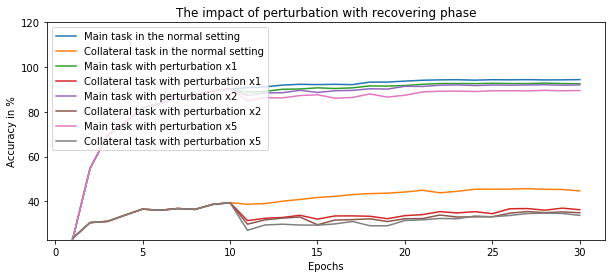

In [11]:
show_results(results, "The impact of perturbation with recovering phase", ymax=120)

Here we see distinctly the 3 phases: the first phase where both tasks are improving, the second where the perturbation reduces significantly the collateral task accuracy while the main task suffers from a lower drop in accuracy (which grows with the perturbation intensity) and the last phase where both models recover. 

As we observe, there is a tradeoff to balance as you can't sabotage the collateral task (CT) without distrubing the main task (MT). For example, with a x2 perturbation, we observe a 10% drop on the CT from 44.7 to 34.9% while the MT has a 2.4% drop from 94.4 to 92.0%.

## Conclusion

This technique is interesting and underlines the existence of a trade off. We would like to improve the search of the best trade-off by doing a joint optimisation of the main task objective and the weighted opposite of the collateral objective.